#### Input

In [1]:
%load_ext autoreload

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from helpers import plot_class
from helpers import helpfunction as helper

pd.options.display.max_columns = None

In [3]:
plt.rcParams.update({'axes.titlesize': 'medium'})
plt.rcParams["axes.titlesize"]
plt_h = 4.7

def get_fig(ncols, nleg):
    fig, ax = plt.subplots(
        ncols=ncols,
        nrows=2,
        figsize=(3.5*ncols+2*nleg, 4.65),
        gridspec_kw={"height_ratios": [3, 1]},
        constrained_layout=True,
    )
    return fig, ax

#### Constants

In [4]:
scale_pot = 6e20
input_file = "./input/Jun2020/after_training.pckl"
output_dir = "./output/nue/datamc/"

In [5]:
sideband = False
run12 = False
run3 = False

pot_dict = {}
master_query = "optical_filter"
title_str = ''

if not run12 + run3 + sideband:
    full_sample = True
    print('Unblinded sample')
    beam_on = "on"
    pot_dict['EXT'] = helper.pot_dict['ext']
    
elif (run12 + run3 + sideband)==1:
    title_str = r"Reconstructed $\nu_e$ Energy > 1.05 GeV"
    beam_on = 'sideband'
    master_query = (
        "(optical_filter & contained_fraction>0.9 & preselect & reco_e>1.05 & n_showers_contained>0)"
    )
    if run12:
        pot_dict = helper.pot_dict['sideband12']
        pot_dict['EXT'] = helper.pot_dict['ext12']
        master_query+= ' & (Run<3 | (sample!=2 & sample!=9))'
        
    elif run3:
        pot_dict = helper.pot_dict['sideband3']
        pot_dict['EXT'] = helper.pot_dict['ext3']
        master_query+= ' & (Run==3 | (sample!=2 & sample!=9))'
    elif sideband:
        pot_dict = helper.pot_dict['sideband']
        pot_dict['EXT'] = helper.pot_dict['ext']
    else:
        print('Not possible!')
else:
    print('Not possible!')
print(beam_on,pot_dict)

Unblinded sample
on {'EXT': 273984645}


In [6]:
%%time
plotter = plot_class.Plotter(
    input_file,
    signal="nue",
    genie_version="mcc9.1",
    beam_on=beam_on,
    pot_dict=pot_dict,
    master_query=master_query,
    load_syst=["weightsFlux", "weightsGenie"],
    show_lee = False
)

Using the spline weights as in MCC9.1 Genie V3 tune 1
All plots are scaled to 4.84e+19 POT, Beam_on data corresponds to 4.84e+19 POT
Loaded all daughter dataframes.
Started loading systematic weights.

Loaded all universes for weightsFlux.
Loaded all universes for weightsGenie.
Electron categories loaded
Initialisation completed!
CPU times: user 14.9 s, sys: 20 s, total: 34.9 s
Wall time: 40.4 s


In [7]:
print(plotter.keys)

{'backtracked_pz', 'nueccinc', 'n_tracks', 'select', 'pfp_clusters_v', 'secondshower_Y_nhit', 'trk_sce_end_y_v', 'weightSplineTimesTune', 'shr_tkfit_2cm_dedx_Y', 'backtracked_py', 'shr_tkfit_nhits_v', 'reco_nu_vtx_x', 'trk_distance_v', 'shr_tkfit_2cm_dedx_wm_v', 'leeweight', 'n_pfp_farvtx', 'n_pfps', 'trk_proton_hypothesis_ratio_v', 'reco_nu_vtx_y', 'npi0', 'score_other_mean', 'shr_tkfit_gap10_dedx_y_v', 'shr_tkfit_4cm_dedx_wm_v', 'nmuon', 'shr_dist_v', 'event_scale', 'trk_theta_v', 'reco_e', 'true_vtx_distance', 'npion', 'backtracked_overlay_purity', 'trk_sce_start_z_v', 'backtracked_completeness', 'trk_at_vtx', 'shr_tkfit_dedx_nhits_y_v', 'nproton', 'pfp_trk_daughters_v', 'shr_tkfit_2cm_nhits_V', 'interaction', 'trk_len_v', 'nu_pdg', 'NeutrinoEnergy2', 'backtracked_px', 'shr_moliere_avg_v', 'shr_tkfit_2cm_nhits_Y', 'CosmicIPAll3D', 'optical_filter', 'sub', 'backtracked_start_z', 'n_showers_contained', 'topological_score', 'trk_muon_hypothesis_ratio_v', 'score_other_min', 'backtracked

In [8]:
print(plotter.title_str)

MicroBooNE 4.8e19$\,$POT, Preliminary


### Plots

#### Additions to signal sample plots

In [ ]:
# purity for every step per  / can take quite some time
if False:
    cats = {2: 11, 1: 10, 3: 1}
    selectors = ["daughter==0 & optical_filter", "e_candidate & preselect", "e_candidate & select"]  # q_s
    labs = ["NeutrinoID", "Pre-selection", "Selection"]

    for selector, lab in zip(selectors, labs):
        ratio, purity = plotter.get_ratio_and_purity(selector, return_syst_err=True)
        print("{} \tPurity: {:.2%}+-{:.2%}".format(lab, *purity))
        print("{} \tRatio: {:.2f}+-{:.2f}".format(lab, ratio[0], ratio[2]))

#### Data/MC comparison

In [ ]:
if full_sample:
    query = (
        "(reco_fid_vol & slpdg==12 & contained_fraction>0.4 & optical_filter & daughter==0)"
    )
    fig, ax = get_fig(3,1)

    ax[0][0].axvspan(0, 0.15, facecolor="red", alpha=0.1)
    ax[1][0].axvspan(0, 0.15, facecolor="red", alpha=0.1)
    ax[0][1].axvspan(0, 15, facecolor="red", alpha=0.1)
    ax[1][1].axvspan(0, 15, facecolor="red", alpha=0.1)
    ax[0][2].axvspan(-1, -.98, facecolor="red", alpha=0.1)
    ax[1][2].axvspan(-1, -.98, facecolor="red", alpha=0.1)
    ax[0][2].axvspan(.98, 1, facecolor="red", alpha=0.1)
    ax[1][2].axvspan(.98, 1, facecolor="red", alpha=0.1)

    ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
        ax.T[0],
        "topological_score",
        r"Event topological score",
        N_bins=20,
        x_min=0,
        x_max=1,
        query=query,
        legend=False,
        title_str=title_str,
        kind="cat",
    )
    plot_class.add_text(ax[0][0], [ratio,purity,ks_p], text_loc)

    ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
        ax.T[1],
        "CosmicIPAll3D",
        r"Cosmic impact parameter (CosmicIPAll3D) [cm]",
        N_bins=20,
        x_min=0,
        x_max=200,
        query=query,
        title_str=title_str,
        legend=False,
        kind="cat",
    )
    plot_class.add_text(ax[0][1], [ratio,purity,ks_p], text_loc)

    ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
        ax.T[2],
        "CosmicDirAll3D",
        r"Cosmic impact direction (CosmicDirAll3D) [cm]",
        N_bins=20,
        x_min=-1,
        x_max=1,
        title_str=title_str,
        query=query,
        legend=True,
        kind="cat",
    )
    plot_class.add_text(ax[0][2], [ratio,purity,ks_p], text_loc)

    fig.savefig(output_dir + "presel_1.pdf", bbox_inches="tight")

In [ ]:
# Preselection queries
if full_sample:
    query = "optical_filter & \
             reco_fid_vol & \
             shr_energy_y_v>0 & \
             shr_tkfit_dedx_nhits_y_v>0 & \
             topological_score > 0.15 & \
             pfp_generation_v==2 & \
             trk_llr_pid_score_v>0.4"


    # the cosmic IP variables demand somehow that there is a shower in the event, therefore, they are left out of this cut.
    fig, ax = get_fig(3,1)

    ax[0][0].axvspan(0.3, 1, facecolor="red", alpha=0.1)
    ax[1][0].axvspan(0.3, 1, facecolor="red", alpha=0.1)
    ax[0][1].axvspan(0.5, 2.5, facecolor="red", alpha=0.1)
    ax[1][1].axvspan(0.5, 2.5, facecolor="red", alpha=0.1)
    ax[0][2].axvspan(0, 100, facecolor="red", alpha=0.1)
    ax[1][2].axvspan(0, 100, facecolor="red", alpha=0.1)

    ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
        ax.T[0],
        "trk_score_v",
        r"Track score",
        N_bins=20,
        x_min=0,
        x_max=1,
        query=query,
        legend=False,
        show_syst=False,
        title_str=title_str,
        kind="pdg",
        y_label="Showers per bin",
    )
    plot_class.add_text(ax[0][0], [None,purity,ks_p], text_loc, y=1/3)
    
    ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
        ax.T[1],
        "pfp_clusters_v",
        r"Number of planes",
        N_bins=3,
        x_min=0.5,
        x_max=3.5,
        query=query,
        legend=False,
        show_syst=False,
        title_str=title_str,
        kind="pdg",
        y_label="Showers per bin",
    )
    plot_class.add_text(ax[0][1], [None,purity,ks_p], text_loc)

    query += " & e_candidate & \
                 slpdg==12 & \
                 contained_fraction>0.4 & \
                 CosmicIPAll3D>30 & \
                 CosmicDirAll3D>-0.98 & \
                 CosmicDirAll3D<0.98"

    ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
        ax.T[2],
        "shr_energy_y_v",
        r"Reconstructed shower energy [GeV]",
        N_bins=20,
        x_min=0,
        x_max=2000,
        query=query,
        legend=True,
        title_str=title_str,
        kind="pdg",
        y_label="Showers per bin",
    )
    plot_class.add_text(ax[0][2], [ratio,purity,ks_p], text_loc, y=1/3)

    ax[0][0].set_ylim(ax[0][0].get_ylim()[1]/5e2, ax[0][0].get_ylim()[1]*1.25)
    ax[0][0].set_yscale("log")
    ax[0][2].set_ylim(max(ax[0][2].get_ylim()[1]/1e3,1), ax[0][2].get_ylim()[1]*1.25)
    ax[0][2].set_yscale("log")

    fig.savefig(output_dir + "presel_2.pdf", bbox_inches="tight")

In [ ]:
query = "(preselect & e_candidate)"

fig, ax = get_fig(2,1)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_theta_v",
    r"Electron candidate $\theta$",
    N_bins=18,
    x_min=0,
    x_max=np.pi,
    query=query,
    legend=False,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p], text_loc)

ax[1][0].set_xticks(helper.theta_ticks)
ax[1][0].set_xticklabels(helper.theta_labs)
ax[0][0].set_xticks(helper.theta_ticks)
ax[0][0].set_xticklabels(helper.theta_labs)


ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_phi_v",
    r"Electron candidate $\phi$",
    N_bins=18,
    x_min=-np.pi,
    x_max=np.pi,
    query=query,
    legend=True,
    title_str=title_str,
    kind="pdg",
    y_max_scaler = 1.1
)
plot_class.add_text(ax[0][1], [None,None,ks_p], text_loc)

ax[1][1].set_xticks(helper.phi_ticks)
ax[1][1].set_xticklabels(helper.phi_labs)
ax[0][1].set_xticks(helper.phi_ticks)
ax[0][1].set_xticklabels(helper.phi_labs)


fig.savefig(output_dir + "e_cand_theta_phi.pdf", bbox_inches="tight")

## Shower fields
1. feature shr_dist_v (0.406786)
2. feature shr_moliere_avg_v (0.115516)
3. feature shr_tkfit_dedx_y_v (0.103206)
4. feature shr_tkfit_2cm_dedx_Y (0.088309)
5. feature shr_tkfit_4cm_dedx_wm_v (0.080856)
6. feature shr_tkfit_gap10_dedx_y_v (0.078377)
7. feature shr_subclusters_v (0.048331)
8. feature secondshower_Y_nhit (0.046542)
9. feature shr_tkfit_hitratio_v (0.032077)

In [ ]:
# Neutrino 2020
fig, ax = get_fig(2,1)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_tkfit_dedx_y_v",
    r"Shower $\frac{dE}{dx}$ (collection plane) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    title_str=title_str,
    query="e_candidate>0 & preselect",
    kind="pdg",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p], text_loc)


ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_dist_v",
    "Shower vertex distance [cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=True,
    title_str=title_str,
    query="e_candidate>0 & preselect",
    
    kind="pdg",
)
plot_class.add_text(ax[0][1], [ratio,purity,ks_p], text_loc)

[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "e_cand_1.pdf", bbox_inches="tight")

In [ ]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_tkfit_2cm_dedx_Y",
    r"Shower $\frac{dE}{dx}$ (collection plane, [0,2]cm) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_tkfit_4cm_dedx_wm_v",
    r"Shower $\frac{dE}{dx}$ (all planes, [0,4]cm) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][1], [ratio,purity,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "shr_tkfit_gap10_dedx_y_v",
    r"Shower $\frac{dE}{dx}$ (collection plane, [1,5]cm) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=True,
    title_str=title_str,
    query="e_candidate>0 & preselect",  
    kind="pdg",
)
plot_class.add_text(ax[0][2], [ratio,purity,ks_p], text_loc)

fig.savefig(output_dir + "e_cand_dedx.pdf", bbox_inches="tight")

In [ ]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_subclusters_v",
    r"Shower number of subclusters",
    N_bins=20,
    x_min=0,
    x_max=40,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_moliere_avg_v",
    r"Shower Moliere angle",
    N_bins=15,
    x_min=0,
    x_max=30,
    legend=False,
    title_str=title_str,
    query="e_candidate>0 & preselect",
    kind="pdg",
)
plot_class.add_text(ax[0][1], [ratio,purity,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "shr_tkfit_hitratio_v",
    r"Fraction of hits in the shower trunk",
    N_bins=20,
    x_min=0,
    x_max=1,
    title_str=title_str,
    legend=True,
    query="e_candidate>0 & preselect",
    kind="pdg",
)
plot_class.add_text(ax[0][2], [ratio,purity,ks_p], text_loc)

fig.savefig(output_dir + "e_cand_2.pdf", bbox_inches="tight")

In [ ]:
fig, ax = get_fig(2,1)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "secondshower_Y_nhit",
    "Second shower number of hits",
    N_bins=20,
    x_min=0,
    x_max=60,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "score",
    r"Electron PID score",
    N_bins=20,
    x_min=0,
    x_max=1,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][1], [ratio,purity,ks_p], text_loc)

fig.savefig(output_dir + "e_cand_3.pdf", bbox_inches="tight")

## Other daughter fields
1. feature trk_llr_pid_score_v (0.382910)
2. feature trk_distance_v (0.201966)
3. feature e_candidate_anglediff (0.081999)
4. feature trk_proton_hypothesis_ratio_v (0.071988)
5. feature trk_score_v (0.068836)
6. feature trk_muon_hypothesis_ratio_v (0.067883)
7. feature pfp_shr_daughters_v (0.050025)
8. feature pfp_generation_v (0.037862)
9. feature pfp_trk_daughters_v (0.036532)

MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $\gamma$: 346. 	#entries 56033
MC category: $e$: 19. 	#entries 31019
Obtained ratio purity and KS test from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $\nu_e$ CC N$\pi$: 9.0 	#entries 21513
MC category: $\nu_e$ CC 0$\pi$0p: 3.2 	#entries 6001
MC category: $\nu_e$ CC 0$\pi$Np: 15. 	#entries 28656
MC category: $\nu_{\mu}$ CC other: 36. 	#entries 5828
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 129. 	#entries 23860
MC category: $\nu$ NC: 14. 	#entries 4950
MC category: $\nu$ NC $\pi^{0}$: 143. 	#entries 14365
MC category: Cosmic: 34. 	#entries 5100
MC category: Out of FV: 35. 	#entries 3051
Obtained ratio purity and KS test from dict


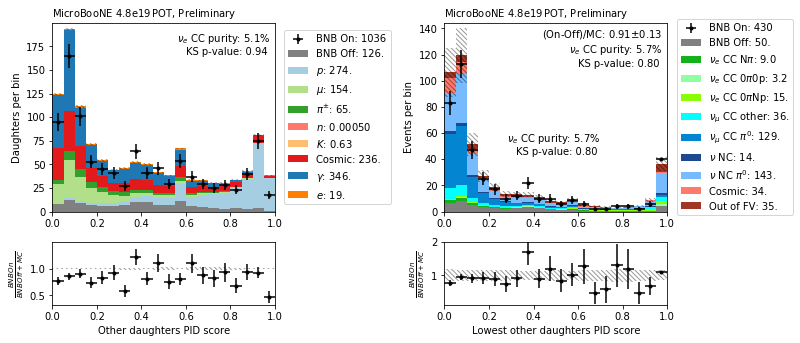

In [11]:
%autoreload
fig, ax = get_fig(2,2)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "score",
    "Other daughters PID score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="pdg",
    y_label="Daughters per bin",
)
plot_class.add_text(ax[0][0], [None,purity,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "score_other_min",
    "Lowest other daughters PID score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="cat",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.7,
    ax[0][1].get_ylim()[1] * 0.3,
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize='medium'
)
plot_class.add_text(ax[0][1], [ratio,purity,ks_p], text_loc)

fig.savefig(output_dir + "daughters_pid.pdf", bbox_inches="tight")

MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $\gamma$: 346. 	#entries 56033
MC category: $e$: 19. 	#entries 31019
Obtained ratio purity and KS test from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $\gamma$: 346. 	#entries 56033
MC category: $e$: 19. 	#entries 31019
Obtained ratio purity and KS test from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#en

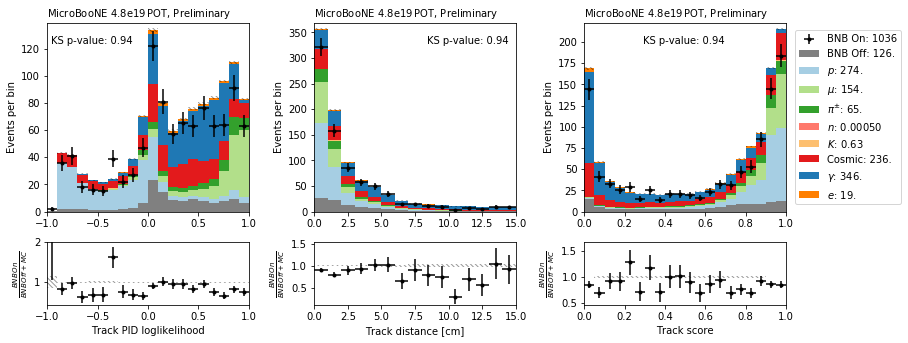

In [12]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_llr_pid_score_v",
    "Track PID loglikelihood",
    N_bins=20,
    x_min=-1,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [None,None,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_distance_v",
    "Track distance [cm]",
    N_bins=15,
    x_min=0,
    x_max=15,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][1], [None,None,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_score_v",
    "Track score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][2], [None,None,ks_p], text_loc)

fig.savefig(output_dir + "pre_daughter_1.pdf", bbox_inches="tight")

MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $\gamma$: 346. 	#entries 56033
MC category: $e$: 19. 	#entries 31019
Obtained ratio purity and KS test from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $\gamma$: 346. 	#entries 56033
MC category: $e$: 19. 	#entries 31019
Obtained ratio purity and KS test from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#en

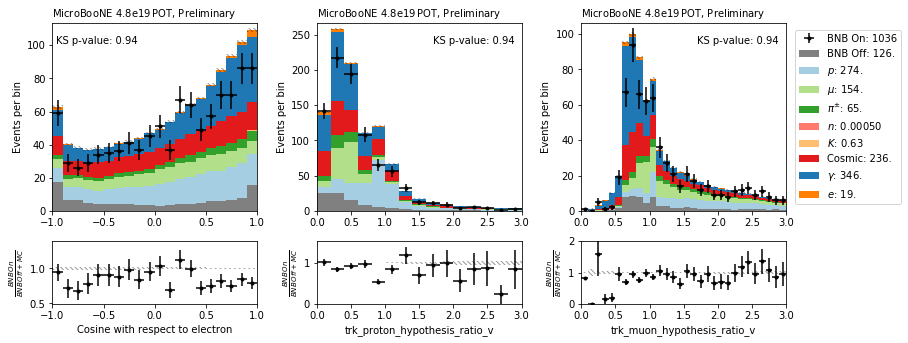

In [13]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "e_candidate_anglediff ",
    "Cosine with respect to electron",
    N_bins=20,
    x_min=-1,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [None,None,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_proton_hypothesis_ratio_v",
    "trk_proton_hypothesis_ratio_v",
    N_bins=15,
    x_min=0,
    x_max=3,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][1], [None,None,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_muon_hypothesis_ratio_v",
    "trk_muon_hypothesis_ratio_v",
    N_bins=30,
    x_min=0,
    x_max=3,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][2], [None,None,ks_p], text_loc)

fig.savefig(output_dir + "pre_daughter_2.pdf", bbox_inches="tight")

MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $\gamma$: 346. 	#entries 56033
MC category: $e$: 19. 	#entries 31019
Obtained ratio purity and KS test from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $\gamma$: 346. 	#entries 56033
MC category: $e$: 19. 	#entries 31019
Obtained ratio purity and KS test from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#en

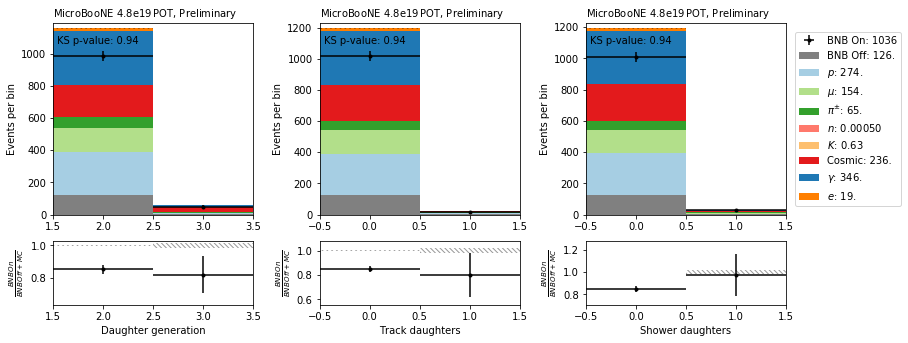

In [14]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "pfp_generation_v",
    "Daughter generation",
    N_bins=2,
    x_min=1.5,
    x_max=3.5,
    query="~e_candidate>0 & preselect",
    title_str=title_str,
    legend=False,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [None,None,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "pfp_trk_daughters_v",
    "Track daughters",
    N_bins=2,
    x_min=-0.5,
    x_max=1.5,
    query="~e_candidate>0 & preselect",
    legend=False,
    kind="pdg",
)
plot_class.add_text(ax[0][1], [None,None,ks_p], text_loc)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "pfp_shr_daughters_v",
    "Shower daughters",
    N_bins=2,
    x_min=-0.5,
    x_max=1.5,
    query="~e_candidate>0 & preselect",
    title_str=title_str,
    legend=True,
    kind="pdg",
)
plot_class.add_text(ax[0][2], [None,None,ks_p], text_loc)

fig.savefig(output_dir + "pre_daughter_3.pdf", bbox_inches="tight")

## Combined BDT
1. feature score (0.623621)
2. feature score_other_mean (0.188310)
3. feature n_showers (0.061185)
4. feature score_other_min (0.043890)
5. feature score_other_max (0.040488)
6. feature n_pfp_farvtx (0.023708)
7. feature contained_fraction (0.018798)

In [ ]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "n_showers",
    r"Number of showers",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="cat",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize='medium'
)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "n_pfpvtx",
    r"Number of particles at vertex",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    legend=False,
    query="e_candidate>0 & preselect",
    kind="cat",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize='medium'
)


ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "hits_ratio",
    r"Fraction of shower-like hits",
    N_bins=20,
    x_min=0,
    x_max=1,
    legend=True,
    title_str=title_str,
    query="e_candidate>0 & preselect",
    
    kind="cat",
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.7,
    ax[0][2].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize='medium'
)

fig.savefig(output_dir + "event_bdt_input.pdf", bbox_inches="tight")

In [ ]:
fig, ax = get_fig(2,2)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "score_event",
    r"$\nu_e$ CC classification score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="(preselect & e_candidate)",
    legend=True,
    title_str=title_str,
    kind="cat",
    
    show_syst=True
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    + r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize='medium'
)


ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_energy_y_v",
    "Electron shower energy [MeV]",
    N_bins=19,
    x_min=100,
    x_max=2000,
    query="(select & e_candidate)",
    legend=True,
    title_str=title_str,
    kind="cat",
    
    show_syst=True,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    + r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize='medium'
)
[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "event_bdt.pdf", bbox_inches="tight")

In [ ]:
fig, ax = get_fig(2,2)

ratio, purity, ks_p, _, text_loc, best_text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_at_vtx",
    r"Track multiplicity at vertex",
    N_bins=6,
    x_min=-0.5,
    x_max=5.5,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="cat",
    show_syst=True,
    
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    + r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize='medium'
)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_at_vtx",
    r"Track multiplicity at vertex",
    N_bins=6,
    x_min=-0.5,
    x_max=5.5,
    legend=True,
    query="e_candidate>0 & select",
    title_str=title_str,
    kind="cat",
    show_syst=True,
    
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    + r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize='medium'
)
[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "trk_at_vtx.pdf", bbox_inches="tight")

after_e = [
    0.0724407,
    0.069931,
    0.070793,
    0.0591427,
    0.0580825,
    0.0707208,
    0.0619271,
    0.0631596,
    0.071956,
    0.0823832,
    0.076636,
    0.0799156,
    0.0945661,
    0.107033,
    0.127387,
    0.148529,
    0.0948171,
]

after_phi = [
    0.0629107,
    0.0574177,
    0.0622805,
    0.0734858,
    0.0484628,
    0.0669408,
    0.0615361,
    0.062214,
    0.098453,
    0.0704486,
    0.0610666,
    0.063518,
]
after_theta = [
    0.0631627,
    0.0555099,
    0.0535565,
    0.0719665,
    0.0884092,
    0.071224,
    0.0889857,
    0.110553,
    0.114683,
    0.0920515,
    0.132373,
    0.349061,
]

before_e = [
    0.29716,
    0.265507,
    0.24898,
    0.260043,
    0.269309,
    0.240034,
    0.263073,
    0.279628,
    0.281871,
    0.269588,
    0.269238,
    0.280828,
    0.295573,
    0.296626,
    0.265467,
    0.293,
    0.288306,
]

before_phi = [
    0.220577,
    0.266154,
    0.241005,
    0.365799,
    0.414711,
    0.245414,
    0.222696,
    0.248814,
    0.252192,
    0.220549,
    0.263487,
    0.255388,
]

before_theta = [
    0.220855,
    0.255422,
    0.287287,
    0.245846,
    0.289416,
    0.314501,
    0.323908,
    0.286917,
    0.231717,
    0.255552,
    0.282183,
    0.406976,
]

In [ ]:
fig, ax = get_fig(3,0)

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_energy_y_v/1000",
    "Electron shower energy [GeV]",
    N_bins=12,
    x_min=0.1,
    x_max=2.5,
    query="(select & e_candidate)",
    legend=False,
    title_str=title_str,
    kind="syst",
    show_data=True,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize='medium'
)


ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_theta_v",
    r"Reconstructed electron $\theta$",
    N_bins=12,
    x_min=0.0,
    x_max=np.pi,
    query="(select & e_candidate)",
    legend=False,
    title_str=title_str,
    kind="syst",
    show_data=True,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize='medium'
)
ax[1][1].set_xticks(helper.theta_ticks)
ax[1][1].set_xticklabels(helper.theta_labs)
ax[0][1].set_xticks(helper.theta_ticks)
ax[0][1].set_xticklabels(helper.theta_labs)
ax[0][1].set_title(r"Reconstructed $\nu_e$ Energy > 1.05 GeV")
ax[0][1].legend(loc="center right")

ratio, purity, ks_p, _, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_phi_v",
    "Reconstructed electron $\phi$",
    N_bins=12,
    x_min=-np.pi,
    x_max=np.pi,
    query="(select & e_candidate)",
    legend=False,
    title_str=title_str,
    kind="syst",
    # syst_fractions=before_phi,
    show_data=True,
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.98,
    ax[0][2].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize='medium'
)
ax[1][2].set_xticks(helper.phi_ticks)
ax[1][2].set_xticklabels(helper.phi_labs)
ax[0][2].set_xticks(helper.phi_ticks)
ax[0][2].set_xticklabels(helper.phi_labs)

_ = [x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "electron_kinematics.pdf", bbox_inches="tight")